# **My first CNN classifier**
## Loading data

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader #to wraps an iterable around the dataset
from torchvision import datasets 
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import shutil#shell utils
import numpy as np

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [ ]:
print(f"Amount of training data: {len(training_data.targets)}, and test data: {len(test_data.targets)}")

Amount of training data: 60000, and test data: 10000


The **DataLoader** object wraps an iterable over our dataset sopporting automatic batching. More about Datasets and DataLoaders [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### Data visualization

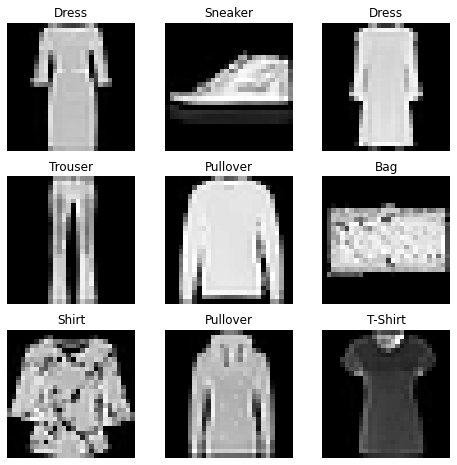

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## **Creating model**
* **__init__ function**: define the network's layers
* **forward function**: how the data will pass through net's layers

In [ ]:
#first set the running device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device} device")

#Defining the model
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(nn.Linear(in_features=28*28, out_features=512),
                                           nn.ReLU(),
                                           nn.Linear(512, 512),
                                           nn.ReLU(),
                                           nn.Linear(512, 10))
    
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

Running on: cuda device


In [ ]:
#let's have a model look
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


if you want to know more about pretrained models available [click here](https://pytorch.org/vision/stable/models.html)

## **Optimizing model parameters**

For train the network we need a loss function (all loss functions available [here](https://pytorch.org/docs/stable/nn.html#loss-functions)) and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
#training loop
def training(model, dataloader, loss_fn, optimizer):
  size = len(dataloader.dataset)#actual dataset size
  model.train()
  for batch_id, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    
    #getting the class predictions
    pred = model(X)
    #computing the loss
    loss = loss_fn(pred, y)

    # weights update
    optimizer.zero_grad() # to "clean" the gradients memory
    loss.backward() # chain rule 
    optimizer.step() # weights updating

    if batch_id % 100 == 0:
      loss, current_sample = loss.item(), batch_id*len(X)
      print(f"loss: {loss:>3f} [{current_sample:>5d}/{size:>5d}]")

In [ ]:
#test loop
def test(model, dataloader, loss_fn):
  size = len(dataloader.dataset)#amount of available data
  num_batches = len(dataloader) 
  model.eval()#avoid the model learning
  test_loss, correct = 0, 0
  # no gradients calculation
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      #get the predictions
      pred = model(X)
      #computing the loss 
      test_loss += loss_fn(pred, y).item() #Returns the value of this tensor as a standard Python number
      correct += (pred.argmax(1)==y).type(torch.float).sum().item()
  
  test_loss /= num_batches
  correct /= size
  acc = 100*correct
  print(f"Test error: \n Acc: {(acc):>0.1f}%, avg loss: {test_loss:>8f}\n")

In [ ]:
epochs = 5
for i in range(epochs):
  print(f"Epoch {i+1}\n ---------------------------")
  training(model, train_dataloader, loss_fn, optimizer)
  test(model, test_dataloader, loss_fn)
print("done")

Epoch 1
 ---------------------------
loss: 2.300589 [    0/60000]
loss: 2.290185 [ 6400/60000]
loss: 2.267891 [12800/60000]
loss: 2.270879 [19200/60000]
loss: 2.235893 [25600/60000]
loss: 2.216253 [32000/60000]
loss: 2.230269 [38400/60000]
loss: 2.184785 [44800/60000]
loss: 2.194162 [51200/60000]
loss: 2.159749 [57600/60000]
Test error: 
 Acc: 46.1%, avg loss: 2.146557

Epoch 2
 ---------------------------
loss: 2.155737 [    0/60000]
loss: 2.147227 [ 6400/60000]
loss: 2.078121 [12800/60000]
loss: 2.103073 [19200/60000]
loss: 2.045417 [25600/60000]
loss: 1.986323 [32000/60000]
loss: 2.026939 [38400/60000]
loss: 1.930722 [44800/60000]
loss: 1.946407 [51200/60000]
loss: 1.877051 [57600/60000]
Test error: 
 Acc: 54.8%, avg loss: 1.863845

Epoch 3
 ---------------------------
loss: 1.898866 [    0/60000]
loss: 1.871133 [ 6400/60000]
loss: 1.736239 [12800/60000]
loss: 1.787665 [19200/60000]
loss: 1.683090 [25600/60000]
loss: 1.633758 [32000/60000]
loss: 1.672157 [38400/60000]
loss: 1.560990

## **Saving our model**
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [ ]:
model.state_dict()

OrderedDict([('linear_relu_stack.0.weight',
              tensor([[ 1.9483e-03, -1.4831e-02, -1.4482e-02,  ..., -3.5126e-02,
                       -2.4499e-02,  1.9545e-02],
                      [ 1.9239e-02,  7.3755e-03, -1.3604e-02,  ...,  2.4648e-02,
                        1.3223e-02, -1.5867e-02],
                      [ 3.5655e-02, -7.8210e-05, -2.8206e-03,  ..., -1.6643e-02,
                       -8.9523e-03, -7.5431e-03],
                      ...,
                      [-3.2757e-02,  1.2092e-02,  2.7388e-02,  ..., -7.2903e-03,
                        2.1290e-02, -3.0681e-02],
                      [ 1.7431e-02,  2.3872e-02, -2.7612e-02,  ...,  1.8316e-02,
                       -1.3312e-02, -1.2902e-02],
                      [ 2.4006e-02, -2.5796e-03, -1.8922e-02,  ...,  2.6491e-02,
                        6.1834e-03,  1.2472e-02]], device='cuda:0')),
             ('linear_relu_stack.0.bias',
              tensor([-0.0170,  0.0221,  0.0279,  0.0277,  0.0281, -0.0227,  0.04

In [ ]:
model_name = "my_first_model.pth"
model_pth = "/content/drive/MyDrive/Cursos/pytorch/models/" + model_name

In [ ]:
torch.save(model.state_dict(), model_pth)
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load(model_pth))
print("model loaded correctly!")

model loaded correctly!


In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
  pred = model(x)
  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  print(f"Predicted: '{predicted}' Actual: '{actual}'")

Predicted: 'Ankle boot' Actual: 'Ankle boot'


# **Using the save model as checkpoint for training step**


### **checkpoint function**
We want to save a chekpoint that allows us to use this information to continue our model traning or just for inference. This is the information:
* **epoch:** numer of times that our model has seen data for weights update
* **valid_loss_min:** the minimum val loss achieved during training phase
* **state_dic:** model architecture information
* **optimizer:** it computes individual learning rates for different parameters

In [ ]:
loaders = {'train': train_dataloader,
           'test': test_dataloader}

use_cuda = torch.cuda.is_available()
if use_cuda:
  model = model.cuda()

In [ ]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):

  """
  state: checkpoint we want to save
  is_best: is this the best checkpoint; min validation loss
  checkpoint_path: path to save checkpoint
  best_model_path: path to save best model
  """
  f_path = checkpoint_path
  # save checkpoint data to the path given, checkpoint_path
  torch.save(state, f_path)
  # if it is a best model, min validation loss
  if is_best:
    best_fpath = best_model_path
    # copy that checkpoint file to best path given, best_model_path
    shutil.copyfile(f_path, best_fpath)

### **Loading function**

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
  """
  checkpoint_path: path to save checkpoint
  model: model that we want to load checkpoint parameters into       
  optimizer: optimizer we defined in previous training
  """
  # load check point
  checkpoint = torch.load(checkpoint_fpath)
  # initialize state_dict from checkpoint to model
  model.load_state_dict(checkpoint['state_dict'])
  # initialize optimizer from checkpoint to optimizer
  optimizer.load_state_dict(checkpoint['optimizer'])
  # initialize valid_loss_min from checkpoint to valid_loss_min
  valid_loss_min = checkpoint['valid_loss_min']
  # return model, optimizer, epoch value, min validation loss 
  return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

### **Training**

In [ ]:
def train(start_epochs, n_epochs, valid_loss_min_input, loaders, model, optimizer, criterion, use_cuda,
          checkpoint_path, best_model_path):
  """
  Keyword arguments:
  start_epochs -- the real part (default 0.0)
  n_epochs -- the imaginary part (default 0.0)
  valid_loss_min_input
  loaders
  model
  optimizer
  criterion
  checkpoint_path
  best_model_path
  
  returns trained model
  """
  # initialize tracker for minimum validation loss
  valid_loss_min = valid_loss_min_input 
  
  for epoch in range(start_epochs, n_epochs+1):
      # initialize variables to monitor training and validation loss
      train_loss = 0.0
      valid_loss = 0.0
      
      ###################
      # train the model #
      ###################
      model.train()
      for batch_idx, (X, y) in enumerate(loaders['train']):
        if use_cuda:
          data, target = X.cuda(), y.cuda()

        ## find the loss and update the model parameters accordingly
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        ## record the average training loss, using something like
        ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
      
      ######################    
      # validate the model #
      ######################
      model.eval()
      for batch_idx, (X, y) in enumerate(loaders['test']):
        if use_cuda:
          data, target = X.cuda(), y.cuda()

        ## update the average validation loss
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
          
      # calculate average losses
      train_loss = train_loss/len(loaders['train'].dataset)
      valid_loss = valid_loss/len(loaders['test'].dataset)

      # print training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, 
          train_loss,
          valid_loss
          ))
      
      # create checkpoint variable and add important data
      checkpoint = {
          'epoch': epoch + 1,
          'valid_loss_min': valid_loss,
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict(),
      }
      
      # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
      
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss
          
  # return trained model
  return model

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Cursos/pytorch/models/checkpoints/current_checkpoint.pt"
best_model_path = "/content/drive/MyDrive/Cursos/pytorch/models/best_model/best_model.pt"

trained_model = train(start_epochs=1, n_epochs=5, valid_loss_min_input=np.Inf, loaders=loaders, 
                      model=model, optimizer=optimizer, criterion=loss_fn, use_cuda=use_cuda, checkpoint_path=checkpoint_path,
                      best_model_path=best_model_path)

Epoch: 1 	Training Loss: 0.000037 	Validation Loss: 0.000215
Validation loss decreased (inf --> 0.000215).  Saving model ...
Epoch: 2 	Training Loss: 0.000034 	Validation Loss: 0.000187
Validation loss decreased (0.000215 --> 0.000187).  Saving model ...
Epoch: 3 	Training Loss: 0.000028 	Validation Loss: 0.000150
Validation loss decreased (0.000187 --> 0.000150).  Saving model ...
Epoch: 4 	Training Loss: 0.000023 	Validation Loss: 0.000125
Validation loss decreased (0.000150 --> 0.000125).  Saving model ...
Epoch: 5 	Training Loss: 0.000019 	Validation Loss: 0.000109
Validation loss decreased (0.000125 --> 0.000109).  Saving model ...


### **Loading the model**
Reconstruct the model

In [ ]:
my_model = NeuralNetwork()
if use_cuda:
  model = model.cuda()
    
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
checkpoint_path = "/content/drive/MyDrive/Cursos/pytorch/models/checkpoints/current_checkpoint.pt"

In [ ]:
# load the saved checkpoint
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

In [ ]:
#Making sure is everything ok
print("model = ", model)
print("optimizer = ", optimizer)
print("start_epoch = ", start_epoch)
print("valid_loss_min = ", valid_loss_min)
print("valid_loss_min = {:.6f}".format(valid_loss_min))

model =  NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
optimizer =  SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
start_epoch =  6
valid_loss_min =  0.0001092103193514049
valid_loss_min = 0.000109


### **Continue training**

In [ ]:
trained_model = train(start_epoch, n_epochs=10, valid_loss_min_input=valid_loss_min, loaders=loaders, 
                      model=model, optimizer=optimizer, criterion=loss_fn, use_cuda=use_cuda, checkpoint_path=checkpoint_path,
                      best_model_path=best_model_path)

Epoch: 6 	Training Loss: 0.000017 	Validation Loss: 0.000099
Validation loss decreased (0.000109 --> 0.000099).  Saving model ...
Epoch: 7 	Training Loss: 0.000016 	Validation Loss: 0.000092
Validation loss decreased (0.000099 --> 0.000092).  Saving model ...
Epoch: 8 	Training Loss: 0.000015 	Validation Loss: 0.000087
Validation loss decreased (0.000092 --> 0.000087).  Saving model ...
Epoch: 9 	Training Loss: 0.000014 	Validation Loss: 0.000083
Validation loss decreased (0.000087 --> 0.000083).  Saving model ...
Epoch: 10 	Training Loss: 0.000013 	Validation Loss: 0.000079
Validation loss decreased (0.000083 --> 0.000079).  Saving model ...
